# Introduction

L'objectif de ce projet est le suivant : 

Étant donnée un texte, est-il possible d'en prédire la "lisibilitée", c'est à dire la difficulté de lecture de ce texte.

Après avoir passer un long moment à essayer d'utiliser BERT et Transformers pour résoudre ce problème, le tout sans succés, j'ai décidé sur les conseils de Pierre de repartir de 0 et de faire un modèle "from scratch", me permettant de mieux comprendre dans sa globalité le traitement nécéssaire au fonctionnement de notre texte dans un réseau de neurones.

C'est donc en utilisant la documentation et les tutoriels NLP de tensorflow que j'ai réussi à mener à bien ce projet

##### Sources :
EDA CommonLit : 
https://www.youtube.com/watch?v=HwZkxUNbWgI&ab_channel=EdanMeyer

plot regression results :
https://dibyendudeb.com/comparing-machine-learning-regression-models-using-python/#Plotting_the_result

tensorflow nlp youtube : https://www.youtube.com/watch?v=fNxaJsNG3-s&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&ab_channel=TensorFlow

regression keras : https://www.tensorflow.org/tutorials/keras/regression

classification pour pre-processing du text : https://www.tensorflow.org/tutorials/keras/text_classification

##### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

##### Chargement des datasets

In [3]:
train_usecols = ['id', 'excerpt', 'target', 'standard_error']
test_usecols = ['id', 'excerpt']
train_df = pd.read_csv("datasets/train.csv", usecols=train_usecols)
test_df = pd.read_csv("datasets/test.csv", usecols=test_usecols)

# EDA

Exemple de texte aléatoire

In [4]:
train_df['excerpt'][3]

'And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, pears, and apples, which bore the whole year round. For the rich south-west wind fed them, till pear grew ripe on pear, fig on fig, and grape on grape, all the winter and the spring. And at the farther end gay flower-beds bloomed through all seasons of the year; and two fair fountains rose, and ran, one through the garden grounds, and one beneath the palace gate, to water all the town. Such noble gifts the heavens had given to Alcinous the wise.\nSo they went in, and saw him sitting, like Poseidon, on his throne, with his golden sceptre by him, in garments stiff with gold, and in his hand a sculptured goblet, as he pledged the merchant kings; and beside him stood Arete, his wise and lovely queen, and leaned against a pillar as she spun her golden threads.'

Suppression des "\n"

In [5]:
train_df['excerpt'] = train_df['excerpt'].apply(lambda x: x.replace('\n', ' '))

Histogramme du nombre de caractères

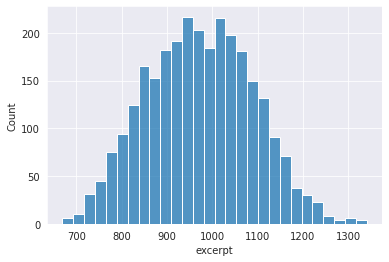

In [6]:
sns.histplot(train_df['excerpt'].apply(len))

Histogramme du nombre de mots

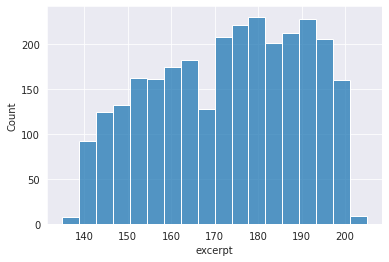

In [7]:
sns.histplot(train_df['excerpt'].apply(lambda x: len(x.split())))

Distribution des résultats "target" 

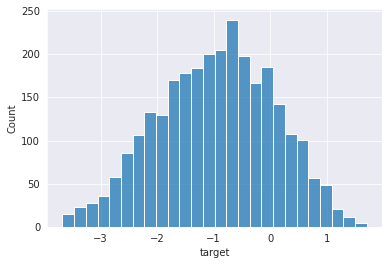

In [8]:
sns.histplot(train_df['target'])

Distribution de "standard_error"

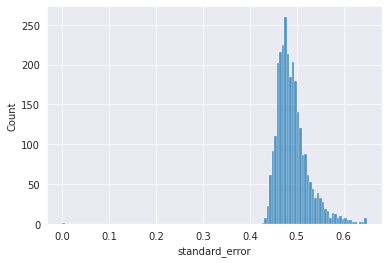

In [9]:
sns.histplot(train_df['standard_error'])

On repère un outliers avec une valeur à 0 -> suppression

In [10]:
train_df = train_df.drop(train_df[train_df['standard_error']==0].index)

Recherche de rapport entre lisibilité et nombre de mots

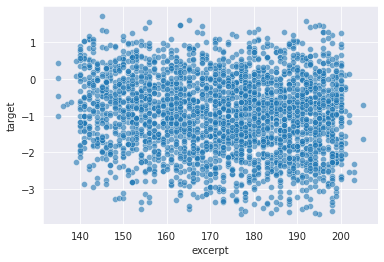

In [11]:
nb_words = train_df['excerpt'].apply(lambda x: len(x.split()))
sns.scatterplot(data=train_df, x = nb_words, y = 'target', alpha=0.6)

# Pre-Processing

Comme expliqué dans l'introduction, nous allons ici utilisé l'API de tensorflow pour réaliser le pre-processing de nos textes

In [12]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Train Valid Split

Séparation du dataset de train en : 
80% train / 20% validation

In [13]:
train_dataset = train_df.sample(frac=0.8, random_state=0)
valid_dataset = train_df.drop(train_dataset.index)

In [14]:
train_dataset.describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
target,-0.952925,1.035124,-3.676268,1.711390
standard_error,0.491892,0.034057,0.428233,0.649671


In [15]:
train_features = train_dataset.copy()
train_labels = train_features.pop('target')

valid_features = valid_dataset.copy()
valid_labels = valid_features.pop('target')

### Tokenisation

Notre dataset maintenant créé, nous allons devoir transformer nos mots afin qu'ils puissent être utilisés dans le model.

Pour cela, nous allons utiliser la classe Tokenizer de l'API de Keras avec 2 arguments :
- Nombre de mots dans le vocabulaire crée
- Token attribué en cas de mot hors du vocabulaire

In [16]:
list_all_words = np.array(train_df['excerpt'].apply(lambda x: x.split()).sum())
len(np.unique(list_all_words))

54376

Nous avons un total de 54376 mots unique selon la méthode .split() ce qui nous permet d'approximer à 50000 la taille de notre vocabulaire.
Pour le oov_token, la documentation recommande "< OOV >"

In [126]:
vocab_size = 10000
oov_token = "<OOV>"

In [127]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

Il suffit d'entrainer sur nos textes sur une array numpy de train_features['excerpt'] avec la méthodes .fit_on_texts

In [128]:
excerpt = np.array(train_features['excerpt'])
tokenizer.fit_on_texts(excerpt)

In [129]:
word_index = tokenizer.word_index
len(word_index)

25490

Voici à quoi ressemble donc notre "vocabulaire"

In [130]:
list(word_index.items())[:15]

[('<OOV>', 1),
 ('the', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ('a', 6),
 ('in', 7),
 ('was', 8),
 ('is', 9),
 ('that', 10),
 ('it', 11),
 ('he', 12),
 ('as', 13),
 ('for', 14),
 ('with', 15)]

### Sequencing

Une fois notre vocabulaire créé, ils n'ont pour l'instant aucun lien entre eux. C'est pour cela qu'il faut crée des "séquences", des suites de token correspondant à chacunes des phrases de notre dataset

In [131]:
sequences = tokenizer.texts_to_sequences(excerpt)

Un exemple du traitement des phrases :

In [132]:
excerpt[0][:74], sequences[0][:12]

('Watergate was a major political scandal that occurred in the United States',
 [8116, 8, 6, 989, 692, 5168, 10, 1969, 7, 2, 392, 277])

In [133]:
for num_word in sequences[0][:12]:
    print(list(word_index.keys())[list(word_index.values()).index(num_word)] + " ")

watergate 
was 
a 
major 
political 
scandal 
that 
occurred 
in 
the 
united 
states 


### Padding

Cependant, à ce stade, chacune des phrases ne fait pas la même taille. 

Dans le domaine du computer vision, il est important que chacunes des images utilisées pour entrainer le model aient les mêmes dimensions. 

Nous faisons face ici au même problème, et une solution simple pour résoudre ce problème est d'utiliser du padding sur nos phrases, autrement dit : combler l'avant ou l'après de notre phrase avec le token [0]

In [134]:
padded = pad_sequences(sequences)
padded.shape

(2266, 215)

On fini par transformer nos dataset de train et validation dans le format final.
Il faut aussi spécifier la taille max de chacune de nos sequence. 

La taille max étant de 215 (.shape), on peut laisser 215 mais ainsi ajouter beaucoup de padding car, mis à part la phrase la plus longue, toutes les autres auront du padding. Ou alors choisir une valeur arbitraires qui devraient correspondre à la plupart des phrases.

Ici, nous choisiront 180

In [135]:
max_len = 180
train_seq = pad_sequences(tokenizer.texts_to_sequences(train_features['excerpt']), maxlen=max_len)
valid_seq = pad_sequences(tokenizer.texts_to_sequences(valid_features['excerpt']), maxlen=max_len)
train_seq.shape, valid_seq.shape

((2266, 180), (567, 180))

Nos datasets sont prets, il est temps de passer à la création de notre model

# Modélisation

Nous utiliserons en baseline le model "basique" présenté dans le tutoriel classification de texte de tensorflow, mais avec une fonction d'activation 'linear', plus adaptée au problème de régression, et 1 seule classe en sortie pour la derniere couche.

Par la suite, afin de comparer différents résultats, nous essaieront de rajouter des couches, modifier le learning rate, rajouter des couches de dropout, ameliorer notre callback...

> Améliorer les performances du reseau de neurones : https://machinelearningmastery.com/improve-deep-learning-performance/





In [136]:
name_model = 'vocab10k_lr_model'

In [145]:
vocab10k_lr_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 24, input_length=max_len),
    layers.GlobalAveragePooling1D(),
    layers.Dense(24, activation='relu'),
    layers.Dropout(.2),
    layers.Dense(12, activation='relu'),
    layers.Dropout(.2),
    layers.Dense(1, activation='linear')
])

La fonction de loss la plus commune étant Mean Squared Error, c'est cette dernière qui sera privilégiée.

De même pour le choix des metriques, nous utiliserons la Mean Absolute Error, ainsi que sa version en pourcentage.

In [146]:
vocab10k_lr_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae', 'mape'])

Ajout d'un callback avec restore_best_weigths=True pour garder la meilleure epoch

In [147]:
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [148]:
NUM_EPOCHS = 200

In [149]:
with tf.device('/device:GPU:0'):
    history = vocab10k_lr_model.fit(train_seq, train_labels, epochs=NUM_EPOCHS, validation_data=(valid_seq, valid_labels), verbose=2, callbacks=callback)

Epoch 1/200
71/71 - 1s - loss: 1.9237 - mae: 1.1194 - mape: 102.6030 - val_loss: 1.8998 - val_mae: 1.1221 - val_mape: 106.6899 - 964ms/epoch - 14ms/step
Epoch 2/200
71/71 - 0s - loss: 1.7894 - mae: 1.0754 - mape: 114.8687 - val_loss: 1.7461 - val_mae: 1.0739 - val_mape: 124.0264 - 332ms/epoch - 5ms/step
Epoch 3/200
71/71 - 0s - loss: 1.6384 - mae: 1.0254 - mape: 132.3438 - val_loss: 1.5734 - val_mae: 1.0201 - val_mape: 150.4178 - 339ms/epoch - 5ms/step
Epoch 4/200
71/71 - 0s - loss: 1.4895 - mae: 0.9742 - mape: 164.7993 - val_loss: 1.3988 - val_mae: 0.9656 - val_mape: 184.7235 - 313ms/epoch - 4ms/step
Epoch 5/200
71/71 - 0s - loss: 1.3406 - mae: 0.9235 - mape: 190.5975 - val_loss: 1.2395 - val_mae: 0.9129 - val_mape: 224.6092 - 291ms/epoch - 4ms/step
Epoch 6/200
71/71 - 0s - loss: 1.2142 - mae: 0.8789 - mape: 230.4687 - val_loss: 1.1191 - val_mae: 0.8701 - val_mape: 263.8070 - 320ms/epoch - 5ms/step
Epoch 7/200
71/71 - 0s - loss: 1.1308 - mae: 0.8507 - mape: 285.4937 - val_loss: 1.0420

## Évaluation des performances

In [154]:
df_hist = pd.DataFrame(history.history)
df_hist['epochs'] = history.epoch
df_hist.head()

,loss,mae,mape,val_loss,val_mae,val_mape,epochs
0,1.923650,1.119389,102.602997,1.899802,1.122105,106.689896,0
1,1.789438,1.075407,114.868706,1.746107,1.073918,124.026360,1
2,1.638371,1.025422,132.343826,1.573387,1.020118,150.417755,2
3,1.489532,0.974170,164.799301,1.398823,0.965577,184.723526,3
4,1.340580,0.923476,190.597488,1.239514,0.912932,224.609238,4


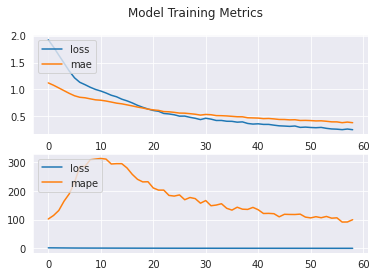

In [156]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Model Training Metrics')

ax1.plot(df_hist['loss'])
ax1.plot(df_hist['mae'])
ax1.legend(['loss', 'mae'], loc='upper left')

ax2.plot(df_hist['loss'])
ax2.plot(df_hist['mape'])
ax2.legend(['loss', 'mape'], loc='upper left')
fig.savefig(f'models/{name_model}/perfplot/training_metrics.png')

1ères prédictions sur notre dataset de validation

In [157]:
valid_predictions = vocab10k_lr_model.predict(valid_seq)

18/18 [==============================] - 0s 2ms/step


In [158]:
valid_predictions.shape, valid_labels.shape

((567, 1), (567,))

In [159]:
valid_predictions = valid_predictions.flatten()

In [160]:
from sklearn import metrics
mape = metrics.mean_absolute_percentage_error(valid_labels, valid_predictions)
mae = metrics.mean_absolute_error(valid_labels, valid_predictions)
mse = metrics.mean_squared_error(valid_labels, valid_predictions)
r2 = metrics.r2_score(valid_labels, valid_predictions)
print('R2 square :', r2)
print('MAE : ', mae)
print('MAPE :', mape)
print('MSE : ', mse)

metrics = {'R2square': r2, 'MAE': mae, 'MAPE': mape, 'MSE': mse}
model_metrics = pd.DataFrame(metrics, index=[0])

R2 square : 0.5536811772182554
MAE :  0.5439777152924823
MAPE : 2.293889488554363
MSE :  0.470811351490031


Ici, le score r2 de 0.55 est dans la moyenne supérieur et signifie que notre model  determine que la moitié du temps la distribution des points.

Cependant, la **MAPE** de 2,3% correspond à dire que en moyenne, notre prédiction est 'éloigné' de seulement 2,3% du veritable résultat

> Comment choisir ses metriques : https://kobia.fr/regression-metrics-quelle-metrique-choisir/#:~:text=La%20MAE%20est%20dans%20la,moins%20le%20mod%C3%A8le%20est%20performant.



Sauvegarde des résultats du model :

In [161]:
model_metrics.to_csv(f'models/{name_model}/metrics.csv')

Un histogramme des erreurs qui suit une distribution gaussienne

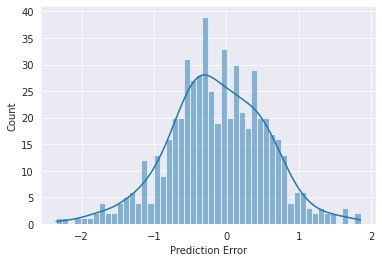

In [162]:
error = valid_predictions - valid_labels
err_pred = sns.histplot(error, bins = 50, kde=True)
err_pred.set(xlabel='Prediction Error', ylabel='Count')
err_pred.get_figure().savefig(f'models/{name_model}/perfplot/error_pred.png')

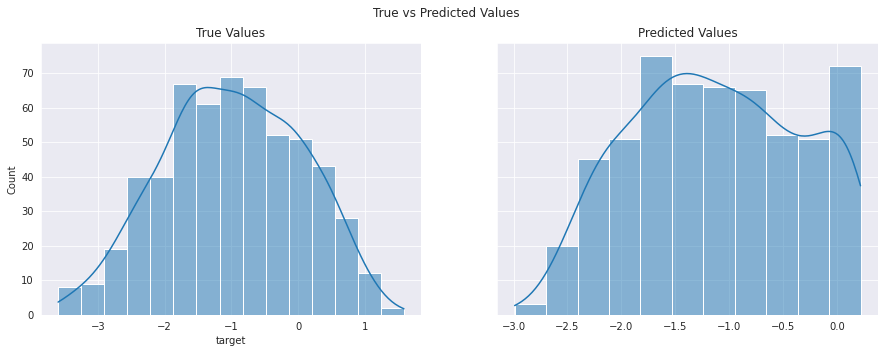

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('True vs Predicted Values')

sns.histplot(ax=axes[0], x=valid_labels, kde=True)
axes[0].set_title('True Values')

sns.histplot(ax=axes[1], x=valid_predictions, kde=True)
axes[1].set_title('Predicted Values')

fig.savefig(f'models/{name_model}/perfplot/true_vs_predicted.png')

Afin de pouvoir comparer et créer notre application à partir de nos models, il faut sauvegarder :
- les 3 plots de comparaison de résultats
- les resultats des métriques
- les poids du model
- le model en format .h5
- le tokenizer

> Sauvegarder un tokenizer : https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring



In [151]:
vocab10k_lr_model.save_weights(f'models/{name_model}/{name_model}')

In [152]:
vocab10k_lr_model.save(f'models/{name_model}/{name_model}.h5')

In [153]:
import json
tokenizer_json = tokenizer.to_json()
with open(f'models/{name_model}/{name_model}_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Conclusion

#### Comparaison des models

Comparons nos différents models :

In [167]:
import ipyplot


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [179]:
baseline_model_img = [
    "/content/models/baseline_model/perfplot/true_vs_predicted.png",
    "/content/models/baseline_model/perfplot/error_pred.png",
    "/content/models/baseline_model/perfplot/training_metrics.png",
]

callback_3lDense_model_img = [
    "/content/models/callback_3lDense_model/perfplot/true_vs_predicted.png",
    "/content/models/callback_3lDense_model/perfplot/error_pred.png",
    "/content/models/callback_3lDense_model/perfplot/training_metrics.png",
]

dropout_model_img = [
    "/content/models/dropout_model/perfplot/true_vs_predicted.png",
    "/content/models/dropout_model/perfplot/error_pred.png",
    "/content/models/dropout_model/perfplot/training_metrics.png",
]

vocab10k_lr_model_img = [
    "/content/models/vocab10k_lr_model/perfplot/true_vs_predicted.png",
    "/content/models/vocab10k_lr_model/perfplot/error_pred.png",
    "/content/models/vocab10k_lr_model/perfplot/training_metrics.png",
]

Le model baseline est déjà assez performant, et c'est un des seul pour lesquels les valeurs préditent montent jusqu'a plus de 1 :


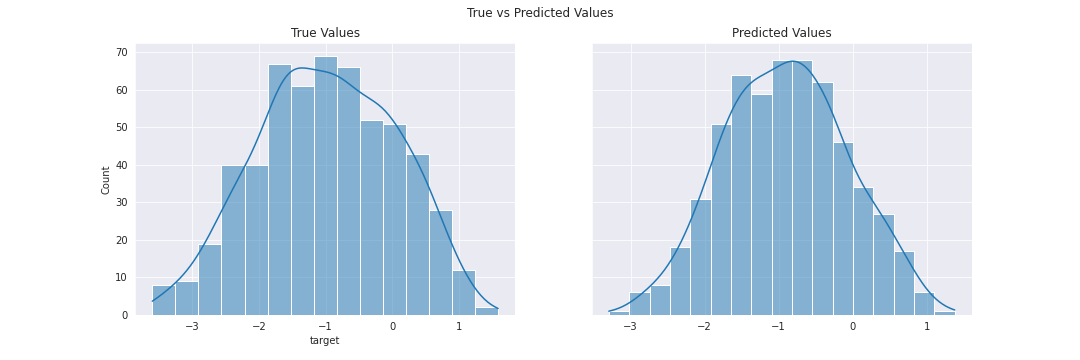
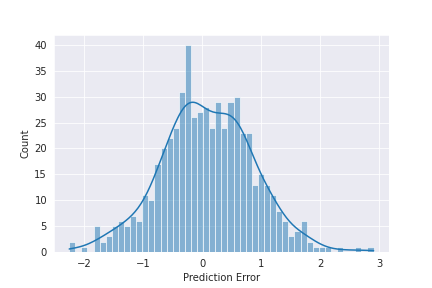
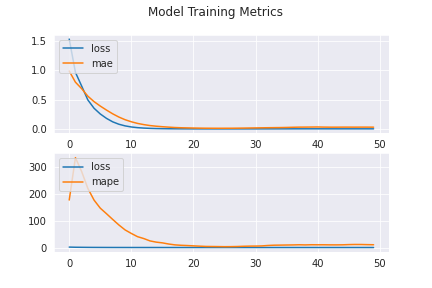


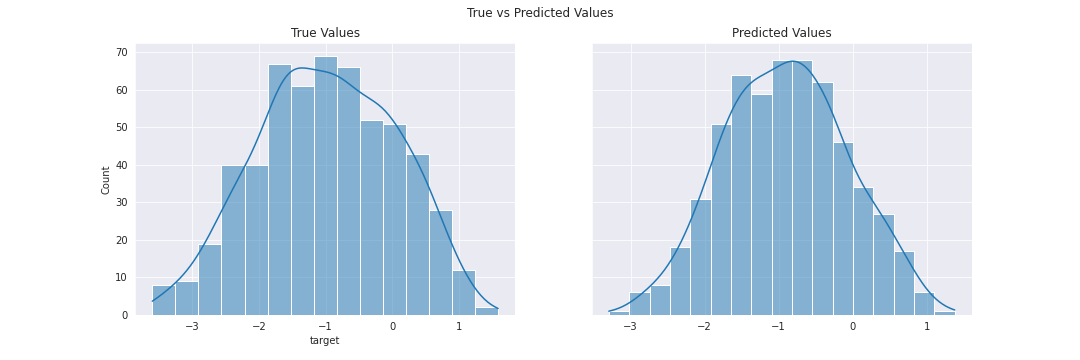
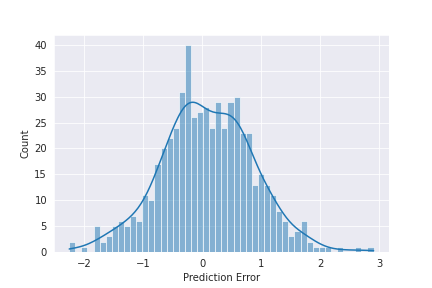
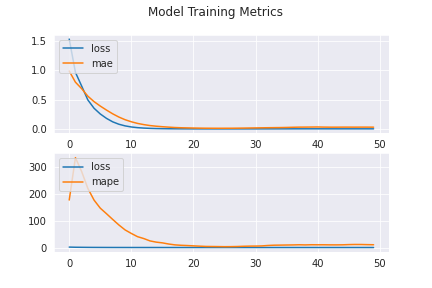

In [186]:
ipyplot.plot_images(baseline_model_img, max_images=3, img_width=500, force_b64=True)


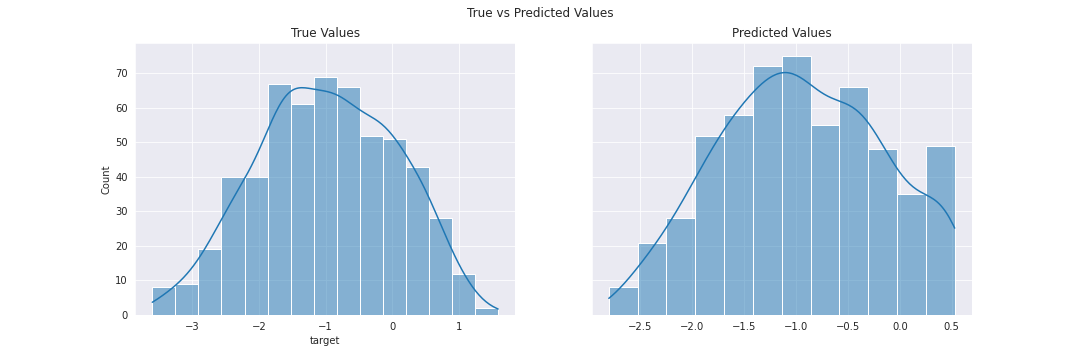
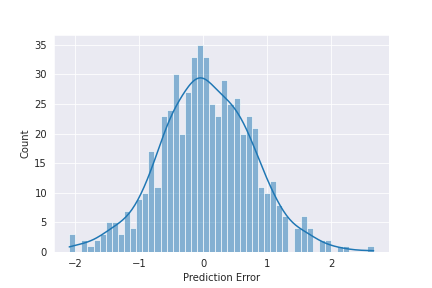
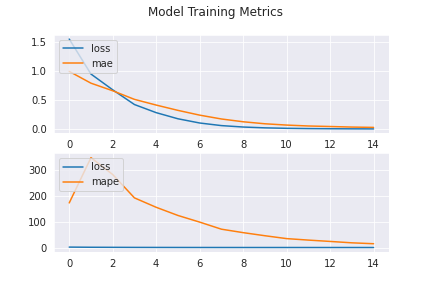


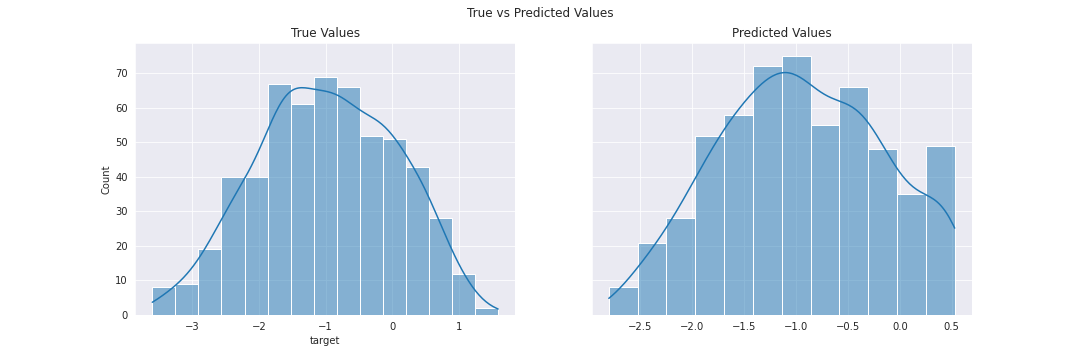
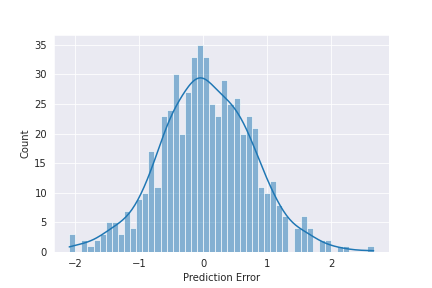
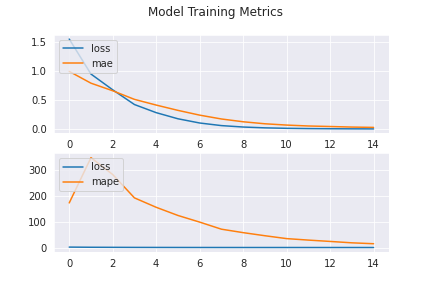

In [178]:
ipyplot.plot_images(callback_3lDense_model_img, max_images=3, img_width=500, force_b64=True)


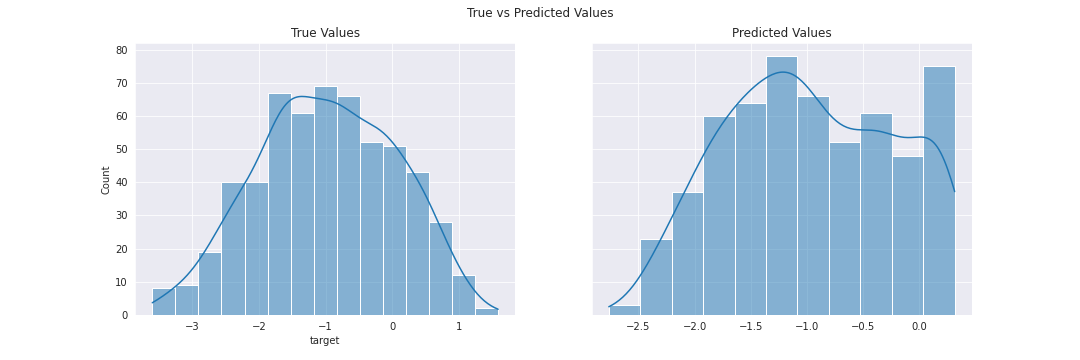
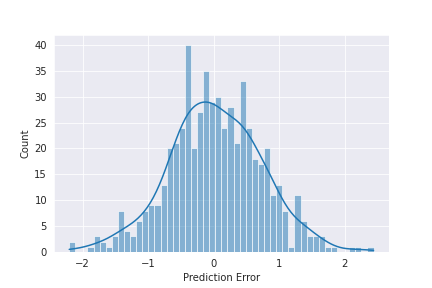
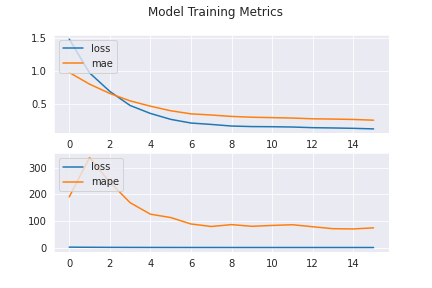


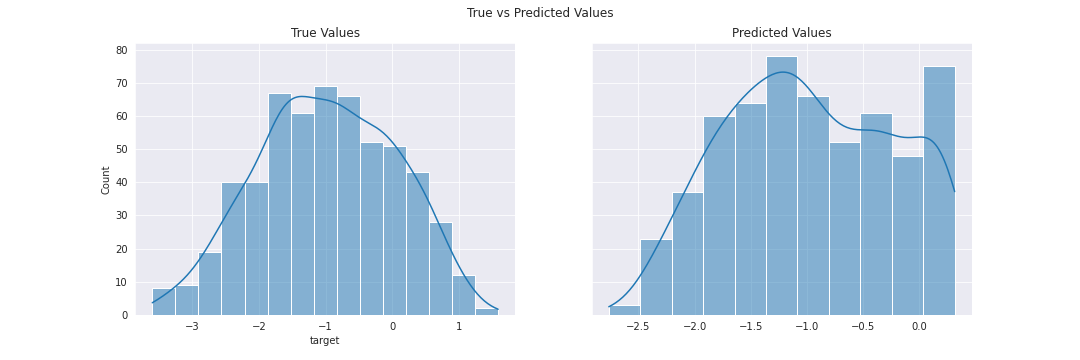
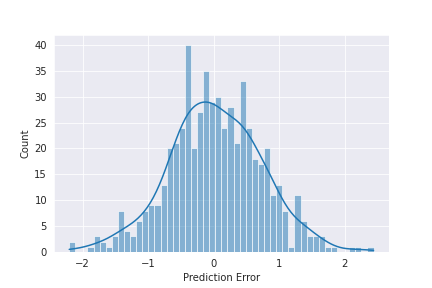
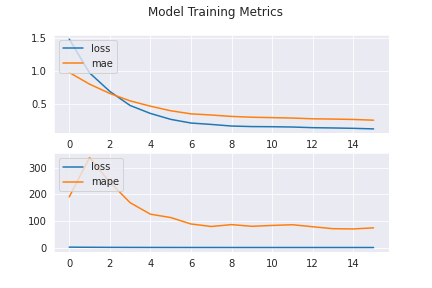

In [180]:
ipyplot.plot_images(dropout_model_img, max_images=3, img_width=500, force_b64=True)


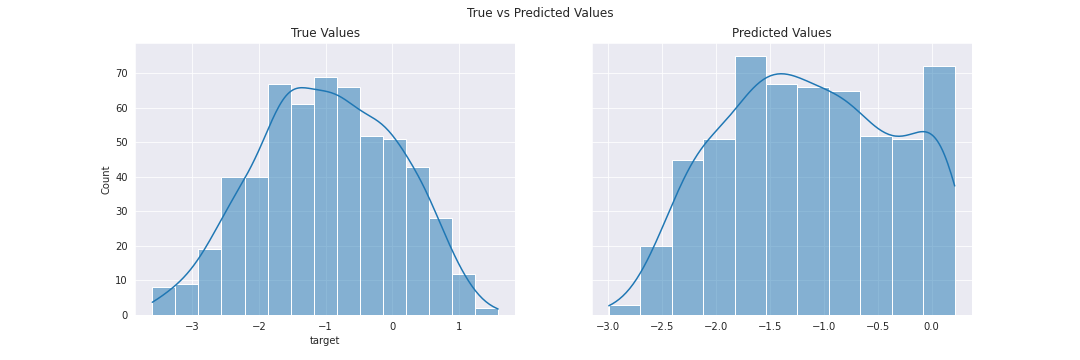
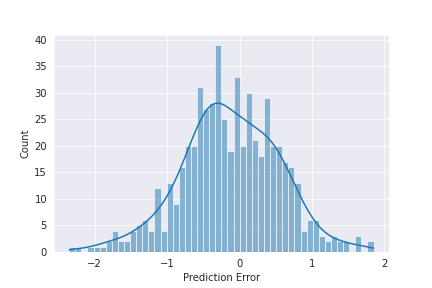
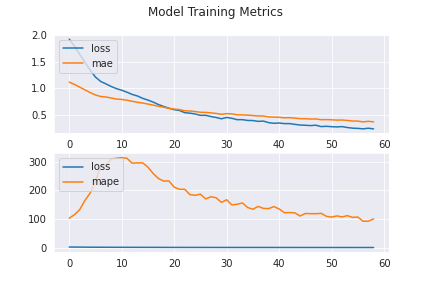


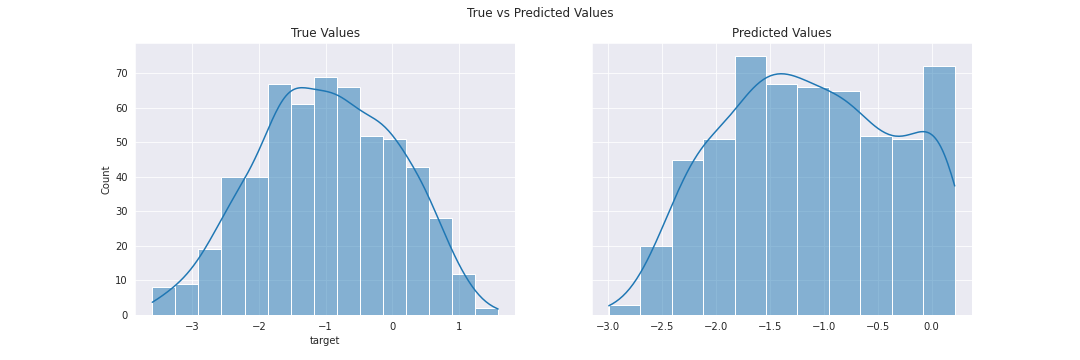
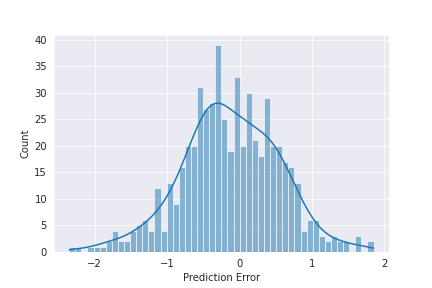
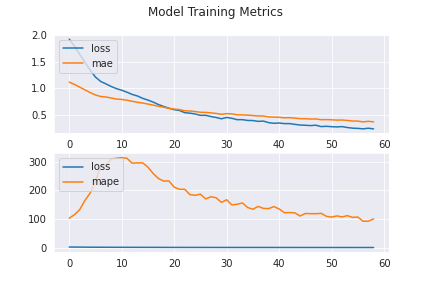

In [181]:
ipyplot.plot_images(vocab10k_lr_model_img, max_images=3, img_width=500, force_b64=True)

Les modèles ont des résultats dans l'ensemble assez moyen car ils ne sont que des modèles from scratch.

Mais ils m'ont permis de comprendre plus en détail comment fonctionne les tokenizer, et comment on peut mettre en place un reseau de neurones pour une tâche de régression.